In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00


In [4]:
from transformers import T5ForConditionalGeneration, pipeline, set_seed
import matplotlib.pyplot as plt
import torch
import math
import tiktoken

In [5]:
# Load Flan-T5 base model
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
sd = model.state_dict()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
# Print parameter names and shapes
for k, v in sd.items():
    print(f"{k}: {v.shape}")

shared.weight: torch.Size([32128, 768])
encoder.embed_tokens.weight: torch.Size([32128, 768])
encoder.block.0.layer.0.SelfAttention.q.weight: torch.Size([768, 768])
encoder.block.0.layer.0.SelfAttention.k.weight: torch.Size([768, 768])
encoder.block.0.layer.0.SelfAttention.v.weight: torch.Size([768, 768])
encoder.block.0.layer.0.SelfAttention.o.weight: torch.Size([768, 768])
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight: torch.Size([32, 12])
encoder.block.0.layer.0.layer_norm.weight: torch.Size([768])
encoder.block.0.layer.1.DenseReluDense.wi_0.weight: torch.Size([2048, 768])
encoder.block.0.layer.1.DenseReluDense.wi_1.weight: torch.Size([2048, 768])
encoder.block.0.layer.1.DenseReluDense.wo.weight: torch.Size([768, 2048])
encoder.block.0.layer.1.layer_norm.weight: torch.Size([768])
encoder.block.1.layer.0.SelfAttention.q.weight: torch.Size([768, 768])
encoder.block.1.layer.0.SelfAttention.k.weight: torch.Size([768, 768])
encoder.block.1.layer.0.SelfAttention.v.w

In [7]:
# Token embeddings
print("Token embeddings:", sd['shared.weight'].view(-1)[:50])

Token embeddings: tensor([-0.4081,  1.2728, -0.1339,  1.2564, -0.1715, -0.2235,  1.0334, -0.1272,
         0.9592,  0.5263,  0.8755,  1.0829,  0.0379, -1.4329, -0.5312, -0.4626,
         0.0264,  0.9964, -1.1071,  0.5365, -0.1666,  0.2942,  0.2144,  0.6390,
        -1.1798, -0.8366,  0.4701,  0.3547, -0.3749,  0.1890, -0.2291, -0.9019,
         0.1634, -0.3505,  0.1266,  0.9990, -0.2680,  0.3757, -1.0434,  2.2135,
         0.3996, -0.5362, -0.6110,  0.3208, -0.5321,  0.4630, -0.9060, -1.2900,
         0.5471,  0.1983])


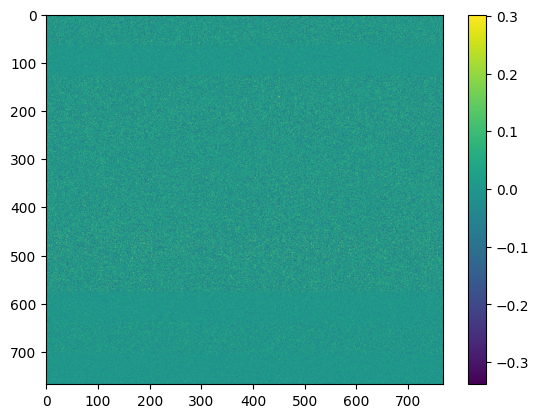

In [8]:
# Plot and save embedding visualizations
plt.imshow(sd['encoder.block.0.layer.0.SelfAttention.q.weight'], cmap='viridis', aspect='auto')
plt.colorbar()
plt.savefig("embedding_q_weight.png")
plt.show()

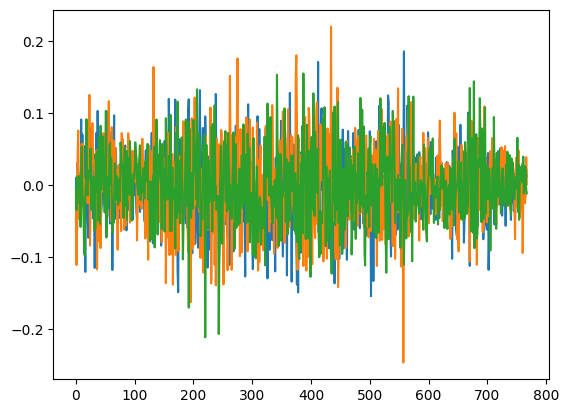

In [9]:
plt.plot(sd['encoder.block.0.layer.0.SelfAttention.q.weight'][:, 50])
plt.plot(sd['encoder.block.0.layer.0.SelfAttention.q.weight'][:, 250])
plt.plot(sd['encoder.block.0.layer.0.SelfAttention.q.weight'][:, 500])
plt.savefig("embedding_q_weight_plot.png")
plt.show()

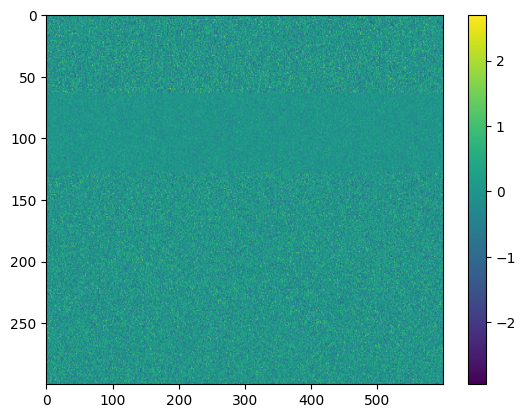

In [10]:
plt.imshow(sd['encoder.block.0.layer.0.SelfAttention.k.weight'][:300, :600], cmap='viridis', aspect='auto')
plt.colorbar()
plt.savefig("embedding_k_weight.png")
plt.show()


In [11]:
# Text generation
generator = pipeline('text2text-generation', model='google/flan-t5-base')
set_seed(42)
print(generator("Translate English to French: 'Hello, how are you?'", max_length=30))

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


[{'generated_text': "'Hello, c'est-ce que tu?'"}]


In [12]:
# Tokenization
encoder = tiktoken.get_encoding("cl100k_base")
data = "This is a sample text for tokenization."
tokens = encoder.encode(data)
print("Tokens:", tokens)

Tokens: [2028, 374, 264, 6205, 1495, 369, 4037, 2065, 13]


In [19]:
tokens_tensor = torch.tensor(tokens[:30 + 1])

# Check if we have enough tokens to reshape
if len(tokens_tensor) >= 31:
    x, y = tokens_tensor[:-1].view(5, 6), tokens_tensor[1:].view(5, 6)
    print("X:", x)
    print("Y:", y)
else:
    print(f"Not enough tokens for reshaping. Tokens available: {len(tokens_tensor)}")

Not enough tokens for reshaping. Tokens available: 9


In [20]:
seq_len = len(tokens_tensor) - 1
if seq_len > 0:
    factor = int(math.sqrt(seq_len))  # Choose a near-square factor
    new_shape = (factor, seq_len // factor) if seq_len % factor == 0 else (seq_len, 1)

    x, y = tokens_tensor[:-1].view(new_shape), tokens_tensor[1:].view(new_shape)
    print("X (Dynamically reshaped):", x)
    print("Y (Dynamically reshaped):", y)


X (Dynamically reshaped): tensor([[2028,  374,  264, 6205],
        [1495,  369, 4037, 2065]])
Y (Dynamically reshaped): tensor([[ 374,  264, 6205, 1495],
        [ 369, 4037, 2065,   13]])


In [14]:
# Model weight comparison
print("Shared weight shape:", sd['shared.weight'].shape)
print("LM head weight shape:", sd['lm_head.weight'].shape)
print("Weights identical:", (sd['shared.weight'] == sd['lm_head.weight']).all())


Shared weight shape: torch.Size([32128, 768])
LM head weight shape: torch.Size([32128, 768])
Weights identical: tensor(False)


In [15]:
# Standard deviation check
x = torch.zeros(768)
print("Initial std:", x.std())
for _ in range(100):
    x += (100**-0.5) * torch.randn(768)
print("Final std:", x.std())

Initial std: tensor(0.)
Final std: tensor(0.9850)


In [16]:
# Cosine learning rate schedule
def cosine_lr_schedule(max_lr, warmup_steps, max_steps, cur_step):
    min_lr = max_lr * 0.1
    if cur_step < warmup_steps:
        return max_lr * (cur_step + 1) / warmup_steps
    if cur_step > max_steps:
        return min_lr
    decay_ratio = (cur_step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

print("LR at step 49:", cosine_lr_schedule(2, 10, 50, 49))

LR at step 49: 0.20277439964018484


In [17]:
# Simple MLP model
net = torch.nn.Sequential(
    torch.nn.Linear(4, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)

torch.random.manual_seed(2024)
x = torch.randn(2, 4)
y = torch.randn(2, 1)

net.zero_grad()
y_hat = net(x)
loss = torch.nn.functional.mse_loss(y_hat, y)
loss.backward()
print("Initial weight gradients:", net[0].weight.grad.view(-1)[:5])

net.zero_grad()
for i in range(2):
    y_hat = net(x[i])
    loss = torch.nn.functional.mse_loss(y_hat, y[i]) / 2
    loss.backward()
print("Final weight gradients:", net[0].weight.grad.view(-1)[:5])

Initial weight gradients: tensor([-0.0023,  0.0463, -0.0194,  0.0343, -0.0029])
Final weight gradients: tensor([-0.0023,  0.0463, -0.0194,  0.0343, -0.0029])
